# Chromosome Painting

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLSO
using BenchmarkTools
using GroupSlices
using LinearAlgebra
using DataFrames
using Plots
# using ProfileView

BLAS.set_num_threads(1)

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1278


In [ ]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=false, max_d=d, phase=true);

Importing reference haplotype data...


Computing optimal haplotypes...100%|████████████████████| Time: 0:00:08


hiiii


# Download population data

Download [population code](ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/) for each 1000 genomes sample. Different population code is explained [here](https://www.internationalgenome.org/category/population/). 

In [4]:
# run this code in terminal
# wget -r -l3 -N --no-parent ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/data/

# Get each sample's population origin

In [5]:
df = DataFrame(sample = String[], population = String[])
sample_to_population = Dict{Symbol, Symbol}()
for population in readdir("data/")
    for sample in readdir("data/" * population)
        sample == ".DS_Store" && continue
        push!(df, (sample, population))
        sample_to_population[Symbol(sample)] = Symbol(population)
    end
end
sample_to_population

Dict{Symbol,Symbol} with 2709 entries:
  :HG02728 => :PJL
  :HG00731 => :PUR
  :NA20902 => :GIH
  :HG02282 => :ACB
  :HG02156 => :CDX
  :HG00684 => :CHS
  :HG01709 => :IBS
  :HG01785 => :IBS
  :HG03055 => :MSL
  :HG00406 => :CHS
  :HG00654 => :CHS
  :HG03642 => :STU
  :HG03886 => :STU
  :HG02025 => :KHV
  :NA19909 => :ASW
  :NA06984 => :CEU
  :NA19431 => :LWK
  :HG00187 => :FIN
  :HG03085 => :MSL
  :NA19773 => :MXL
  :HG03636 => :PJL
  :HG01790 => :GBR
  :HG00478 => :CHS
  :HG03782 => :ITU
  :HG00607 => :CHS
  ⋮        => ⋮

# Compute sample composition in 1000 genomes

In [ ]:
# compute each person's phase information
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
Random.seed!(2020)
chr = 18
maf = 0.1
d = 1000
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.maxd$d.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.vcf.gz"
@time ph = phase(tgtfile, reffile, outfile=outfile, impute=false, max_d=d, phase=true);

Importing reference haplotype data...


Importing genotype file...100%|█████████████████████████| Time: 0:00:05


In [7]:
# need compressed reference panel
compressed_Hunique = JLSO.load(reffile)[:compressed_Hunique]

# get sample's ancestry
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reader = VCF.Reader(openvcf(tgtfile, "r"))
tgtID  = VCF.header(reader).sampleID
sample_population = [sample_to_population[Symbol(id)] for id in tgtID];

In [8]:
findall(x -> x == :CHS, sample_population)

8-element Array{Int64,1}:
  4
  5
  6
  7
  8
  9
 10
 11

  0.081895 seconds (132.43 k allocations: 6.762 MiB)
  0.001856 seconds (5 allocations: 688 bytes)
  0.002878 seconds (5 allocations: 688 bytes)


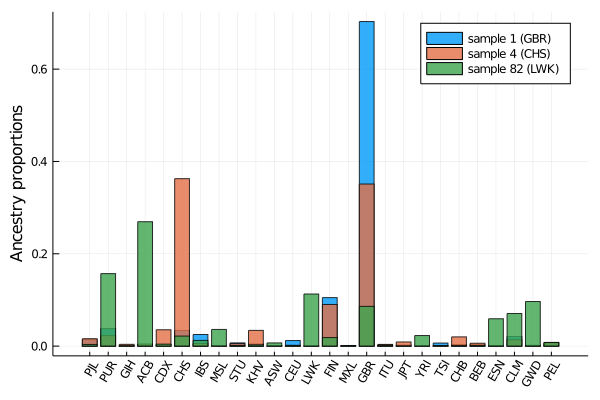

In [9]:
populations = MendelImpute.unique_populations(sample_to_population)
@time sample1_comp = paint(ph[1], sample_to_population, compressed_Hunique, 
    populations=populations)
@time sample4_comp = paint(ph[4], sample_to_population, compressed_Hunique, 
    populations=populations)
@time sample82_comp = paint(ph[82], sample_to_population, compressed_Hunique, 
    populations=populations)

barplot = bar(sample1_comp, xticks=(1:1:26, string.(populations)), xrotation=60, 
    ylabel = "Ancestry proportions", label="sample 1 (GBR)", alpha=0.8)
bar!(barplot, sample4_comp, label="sample 4 (CHS)", alpha=0.8)
bar!(barplot, sample82_comp, label="sample 82 (LWK)", alpha=0.8)

In [10]:
savefig(barplot, "admixture.png") # remember to set dpi=300